In [ ]:
# ===================================================================
# BENCHMARKING RESULTS DATA LOADING
# ===================================================================

import pickle

# Load comprehensive benchmarking results from previous analysis
# This dataset contains processed results from multiple denoising algorithms
# applied to synthetic IFU spectral cubes across various SNR levels and source sizes
with open('/Users/arnablahiry/repos/3D_IFU_Denoising/stats/final_dataset_stats.pkl', 'rb') as f:
    df_sampled = pickle.load(f)

# IFU Denoising Algorithm Performance Comparison

## Overview
This notebook provides comprehensive visualization and analysis of multiple denoising algorithms' performance on synthetic IFU (Integral Field Unit) spectral cube datasets. The analysis focuses on two key metrics across different observational regimes:

1. **RMSE Reduction**: Measures noise suppression effectiveness
2. **Flux Conservation**: Evaluates photometric accuracy preservation

## Scientific Context

### Algorithms Compared
- **U-Net3D**: Deep learning approach with 3D convolutional neural network
- **2D1D-IST**: Iterative Soft Thresholding using 2D-1D wavelet decomposition
- **PCA**: Principal Component Analysis for signal-noise separation
- **ICA**: Independent Component Analysis for component decomposition

### Analysis Framework
- **Source Classification**: Resolved vs Unresolved sources relative to beam size
- **SNR Binning**: Performance analysis across signal-to-noise ratio ranges
- **Statistical Evaluation**: Error bars and trend analysis for robust conclusions

### Applications
This analysis enables:
- Algorithm selection for specific observational datasets
- Understanding performance trade-offs between noise reduction and accuracy
- Identifying optimal SNR regimes for each denoising method
- Validation of algorithm behavior across source size categories

---

## Data Loading and Initial Processing

In [ ]:
# ===================================================================
# DATA SEGREGATION BY SOURCE RESOLUTION
# ===================================================================

# Separate data by source size relative to beam resolution
# This fundamental classification affects algorithm performance significantly

# Unresolved sources: diameter ≤ beam size (beam-limited observations)
# These sources are dominated by instrumental PSF effects
df_unresolved = df_sampled[df_sampled['beam_size_bin'] == 'Unresolved']

# Resolved sources: diameter > beam size (spatially resolved observations)  
# These sources show intrinsic spatial structure beyond beam convolution
df_resolved = df_sampled[df_sampled['beam_size_bin'] == 'Resolved']

# Create list for systematic processing of both categories
dfs = [df_unresolved, df_resolved]

In [ ]:
# Display sample counts for statistical validation
# These numbers confirm adequate sampling for robust statistical analysis
print("Number of unresolved source samples:", len(list(df_unresolved['clean_cube'])))
print("Number of resolved source samples:", len(list(df_resolved['clean_cube'])))

350
350


# Dataset Statistics and Structure Analysis

## Data Distribution Overview
Let's examine the distribution of sources across resolution categories and SNR bins to understand the statistical basis for our comparison.

In [ ]:
# Examine available SNR bins for systematic analysis
# This shows the range of signal-to-noise conditions tested
print("Available SNR bins for resolved sources:")
for snr_bin in df_resolved["peak_snr_bin"].cat.categories:
    print(f"  {snr_bin}")

(2.5, 3.0]
(3.0, 3.5]
(3.5, 4.0]
(4.0, 5.0]
(5.0, 6.0]
(6.0, 8.0]
(8.0, 10.0]


In [ ]:
# ===================================================================
# ALGORITHM LABEL MAPPING FOR VISUALIZATION
# ===================================================================

# Define professional labels for each denoising method
# These labels will appear in plots and legends for clear identification
method_map = {
    'rmse_masked_unet': 'U-Net3D-64',                    # Deep learning approach with 64 filters
    'rmse_masked_IST': '2D1D-IST-5'+r'$\sigma$',        # Iterative Soft Thresholding at 5σ threshold
    'rmse_masked_PCA': 'PCA',                            # Principal Component Analysis
    'rmse_masked_ICA': 'ICA',                            # Independent Component Analysis
    'rmse_masked_noisy': 'Noisy'                         # Original noisy baseline for comparison
}

# Algorithm Label Configuration

## Method Naming Convention
Define consistent labels for all denoising algorithms for professional visualization. This mapping ensures clear identification of methods in plots and maintains consistency across different analysis sections.

In [ ]:
# ===================================================================
# VISUALIZATION LIBRARIES AND UTILITIES
# ===================================================================

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# ===================================================================
# DATA PROCESSING UTILITIES
# ===================================================================

def flatten_scalar(x):
    """
    Flatten single-element containers to scalar values for consistent processing.
    
    This utility function handles cases where performance metrics might be
    stored as single-element tuples, lists, or arrays, ensuring they become
    scalar values for mathematical operations and plotting.
    
    Parameters
    ----------
    x : various types
        Input that might be a container with single element or already scalar
        
    Returns
    -------
    scalar
        Flattened scalar value for consistent numerical processing
    """
    if isinstance(x, (tuple, list, np.ndarray)) and len(x) == 1:
        return x[0]
    return x

# Configure matplotlib for professional publication-quality plots
plt.style.use('default')

# ===================================================================
# RMSE CALCULATION FOR ALL ALGORITHMS
# ===================================================================

# Define method identifiers and algorithm modes for systematic processing
methods = ['rmse_masked_noisy', 'rmse_masked_unet', 'rmse_masked_IST', 'rmse_masked_PCA', 'rmse_masked_ICA']
modes = ['noisy', 'unet', 'IST', 'PCA', 'ICA']

# Algorithm label mapping for consistent visualization
method_map = {
    'rmse_masked_unet': 'U-Net3D-64',
    'rmse_masked_IST': '2D1D-IST-5'+r'$\sigma$',
    'rmse_masked_PCA': 'PCA',
    'rmse_masked_ICA': 'ICA',
    'rmse_masked_noisy': 'Noisy'
}

# Calculate RMSE for each algorithm within emission regions
for i, method in enumerate(methods):
    if i == 0:
        # Calculate baseline RMSE for noisy input (reference for comparison)
        df_sampled[method] = (
            df_sampled.apply(
                lambda row: 
                    np.sqrt(mean_squared_error(
                        (row['clean_mask']*row['clean_cube']).ravel(),
                        (row['clean_mask']*row["noisy_cube"]).ravel()
                    )) * 100 if row["noisy_cube"].size > 0 else 0.0,
                axis=1
            )
        )
    else:
        # Calculate RMSE for each denoising algorithm
        mode = modes[i] 
        df_sampled[method] = (
            df_sampled.apply(
                lambda row: 
                    np.sqrt(mean_squared_error(
                        (row['clean_mask']*row['clean_cube']).ravel(),
                        (row['clean_mask']*row[f"{mode}_denoised_cube"]).ravel()
                    )) * 100 if row[f"{mode}_denoised_cube"].size > 0 else 0.0,
                axis=1
            )
        )

# ===================================================================
# RMSE REDUCTION RATIO CALCULATION
# ===================================================================

# Compute RMSE reduction ratio for performance comparison
# Values < 1.0 indicate improvement over baseline noise level
for method in methods:
    reduction_col = f'{method}_reduction'
    df_sampled[reduction_col] = (
        df_sampled.apply(
            lambda row: (
                flatten_scalar(row[method]) /
                flatten_scalar(row['rmse_masked_noisy'])
            ),
            axis=1
        )
    )

# RMSE Metric Calculation and Processing

## Performance Metric Framework
Calculate Root Mean Square Error (RMSE) metrics for all denoising algorithms to quantify noise reduction effectiveness. The RMSE provides a standardized measure of how well each algorithm removes noise while preserving source structure.

### Key Concepts:
- **Absolute RMSE**: Direct comparison between denoised and ground truth
- **RMSE Reduction**: Ratio of denoised RMSE to original noisy RMSE 
- **Values < 1.0**: Indicate improvement over baseline noise level
- **Emission Mask Focus**: Concentrates analysis on scientifically relevant regions

---

/tmp/ipykernel_3115821/3378506669.py:79: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_method.groupby('peak_snr_bin')
/tmp/ipykernel_3115821/3378506669.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_method.groupby('peak_snr_bin')


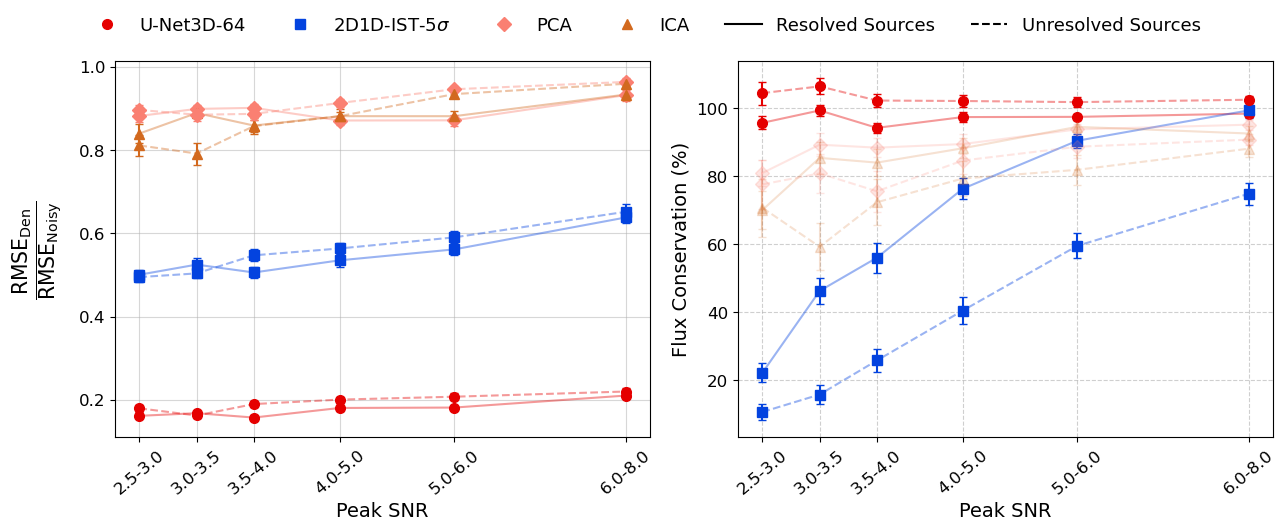

In [ ]:
# ===================================================================
# COMPREHENSIVE ALGORITHM PERFORMANCE VISUALIZATION
# ===================================================================

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
import sys
import os
sys.path.append(os.path.abspath('/Users/arnablahiry/repos/3D_IFU_Denoising/src'))
from functions import *              

# ===================================================================
# UTILITY FUNCTIONS FOR DATA PROCESSING
# ===================================================================

def flatten_scalar(x):
    """
    Flatten single-element containers to scalar values for consistent processing.
    
    Essential for handling performance metrics that may be returned as 
    single-element tuples from statistical calculations.
    """
    if isinstance(x, (tuple, list, np.ndarray)) and len(x) == 1:
        return x[0]
    return x

# Set professional plotting style for publication-quality figures
plt.style.use('default')

# ===================================================================
# FLUX CONSERVATION METRIC CALCULATION
# ===================================================================

# Define flux conservation methods and corresponding algorithm modes
methods_flux = ['flux_conservation_unet', 'flux_conservation_IST', 'flux_conservation_PCA', 'flux_conservation_ICA']
modes_flux = ['unet', 'IST', 'PCA', 'ICA']

# Label mapping for flux conservation analysis
method_map_flux = {
    'flux_conservation_unet': 'U-Net3D-64',
    'flux_conservation_IST': '2D1D-IST-5'+r'$\sigma$',
    'flux_conservation_PCA': 'PCA',
    'flux_conservation_ICA': 'ICA',
}

# Calculate flux conservation percentage for each algorithm
# Formula: (flux_denoised / flux_ground_truth) × 100%
for i, method in enumerate(methods_flux):
    mode = modes_flux[i] 
    df_sampled[method] = (
        df_sampled.apply(
            lambda row: 
                100 * np.sum(row['clean_mask']*row[f"{mode}_denoised_cube"]) / 
                np.sum(row['clean_mask']*row["clean_cube"]) 
                if row[f"{mode}_denoised_cube"].size > 0 else 0.0,
            axis=1
        )
    )

# ===================================================================
# DATA PREPARATION FOR RMSE REDUCTION VISUALIZATION
# ===================================================================

# Reshape data for systematic plotting using pandas melt
reduction_df = df_sampled.melt(
    id_vars=['peak_snr_bin', 'beam_size_bin'],               # Keep grouping variables
    value_vars=[f'{m}_reduction' for m in methods],          # Metrics to analyze
    var_name='Method', value_name='RMSE_Reduction_Percent'   # New column names
)

# Apply method label mapping for professional visualization
reduction_df['Method'] = reduction_df['Method'].map(lambda x: method_map[x.replace('_reduction', '')])

# Flatten scalar values and remove missing data for clean analysis
reduction_df['RMSE_Reduction_Percent'] = reduction_df['RMSE_Reduction_Percent'].apply(flatten_scalar)
reduction_df = reduction_df.dropna(subset=['RMSE_Reduction_Percent'])

# ===================================================================
# VISUALIZATION SETUP AND CONFIGURATION
# ===================================================================

# Define visual elements for consistent, professional appearance
markers = ['o', 's', 'D', '^', 'v']                        # Distinct markers for each algorithm
colors = ['xkcd:red', 'xkcd:blue', 'salmon', 'chocolate', 'green']  # Color scheme for clarity
beam_size_order = sorted(df_sampled['beam_size_bin'].unique())       # Consistent ordering

# Identify and optionally exclude edge bins with limited statistics
last_bin = reduction_df['peak_snr_bin'].sort_values().unique()[-1]
# Uncomment to exclude last bin: reduction_df = reduction_df[reduction_df['peak_snr_bin'] != last_bin]

# Create dual-panel figure for comprehensive analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5.1))

# ===================================================================
# PANEL 1: RMSE REDUCTION ANALYSIS
# ===================================================================

# Initialize legend tracking to prevent duplicate entries
legend_labels = {method: False for method in method_map.values()}

# Initialize tick positioning for consistent x-axis formatting
xtick_bins = []
xtick_labels = []
seen_bins = set()

# Process each beam size category systematically
for i, beam_size in enumerate(beam_size_order):
    # Filter data for current beam size category
    df_sub = reduction_df[reduction_df['beam_size_bin'] == beam_size]
    
    # Set line style: dashed for unresolved, solid for resolved sources
    linestyle = '--' if i == 1 else '-'

    # Initialize line data storage for connecting points
    line_x = {m: [] for m in method_map.values()}
    line_y = {m: [] for m in method_map.values()}
    
    # Process each algorithm within current beam size category
    for method_idx, method in enumerate(list(method_map.values())[:-1]):  # Exclude 'Noisy' baseline
        df_method = df_sub[df_sub['Method'] == method]
        
        # Group by SNR bin and calculate statistics
        grouped = df_method.groupby('peak_snr_bin')
        for name, group in list(grouped)[:-1]:  # Exclude last bin if needed
            
            # Calculate bin center for x-axis positioning
            bin_center = (name.left + name.right) / 2
            
            # Compute mean performance and standard error
            mean_val = group['RMSE_Reduction_Percent'].mean()
            std_err = group['RMSE_Reduction_Percent'].std() / np.sqrt(len(group))
            
            # Track x-axis ticks to avoid duplication
            if bin_center not in seen_bins:
                xtick_bins.append(bin_center)
                xtick_labels.append(f"{name.left:.1f}-{name.right:.1f}")
                seen_bins.add(bin_center)

            # Plot data point with error bars
            ax1.errorbar(
                bin_center, mean_val, yerr=std_err,
                fmt=markers[method_idx], color=colors[method_idx],
                linestyle='none', markersize=7, capsize=3,
                label=method if not legend_labels[method] else ""
            )
            
            # Update legend tracking and store line data
            legend_labels[method] = True
            line_x[method].append(bin_center)
            line_y[method].append(mean_val)

    # Draw connecting lines between points for trend visualization
    for method_idx, method in enumerate(method_map.values()):
        ax1.plot(
            line_x[method], line_y[method],
            color=colors[method_idx], linestyle=linestyle, alpha=0.4
        )

# ===================================================================
# PANEL 1: AXIS FORMATTING AND LABELS
# ===================================================================

ax1.set_title(" ")  # Empty title for clean appearance
ax1.set_xlabel("Peak SNR", fontsize=14)
ax1.set_ylabel(r"$\frac{\rm{RMSE_{Den}}}{\rm{RMSE_{Noisy}}}$", fontsize=21, rotation=90, labelpad=10)
ax1.grid(True, which='major', linestyle='-', alpha=0.5)
ax1.set_xticks(xtick_bins)
ax1.set_xticklabels(xtick_labels, rotation=40)

# Format tick labels for professional appearance
for label in ax1.get_xticklabels():
    label.set_fontweight('normal')
    label.set_fontsize(12)
for label in ax1.get_yticklabels():
    label.set_fontweight('normal')
    label.set_fontsize(12)

# ===================================================================
# FLUX CONSERVATION DATA PREPARATION
# ===================================================================

# Define flux conservation methods (excluding 'Noisy' baseline)
methods1 = ['flux_conservation_unet', 'flux_conservation_IST', 'flux_conservation_PCA', 'flux_conservation_ICA']
method_map1 = {
    'flux_conservation_unet': 'U-Net3D-64',
    'flux_conservation_IST': '2D1D-IST-5'+r'$\sigma$',
    'flux_conservation_PCA': 'PCA',
    'flux_conservation_ICA': 'ICA'
}

# Prepare flux conservation data (values already represent percentages)
for method in methods1:
    improvement_col = f'{method}_improvement'
    df_sampled[improvement_col] = (df_sampled[method])

# Reshape flux conservation data for systematic plotting
improvement_df = df_sampled.melt(
    id_vars=['peak_snr_bin', 'beam_size_bin'],
    value_vars=[f'{m}_improvement' for m in methods1],
    var_name='Method', value_name='Flux_Conservation_Improvement_Percent'
)

# Apply label mapping and data cleaning
improvement_df['Method'] = improvement_df['Method'].map(lambda x: method_map1[x.replace('_improvement', '')])
improvement_df['Flux_Conservation_Improvement_Percent'] = improvement_df['Flux_Conservation_Improvement_Percent'].apply(flatten_scalar)
improvement_df = improvement_df.dropna(subset=['Flux_Conservation_Improvement_Percent'])

# ===================================================================
# PANEL 2: FLUX CONSERVATION ANALYSIS
# ===================================================================

# Configure visual elements for flux conservation plot
markers = ['o', 's', 'D', '^']  # Four algorithms (no 'Noisy' baseline)
colors = ['xkcd:red', 'xkcd:blue', 'salmon', 'chocolate']
beam_size_order = sorted(df_sampled['beam_size_bin'].unique())

# Initialize legend tracking for Panel 2
legend_labels = {method: False for method in method_map1.values()}

# Reset tick tracking for Panel 2
xtick_bins = []
xtick_labels = []
seen_bins = set()

# Process flux conservation data by beam size category
for i, beam_size in enumerate(beam_size_order):
    df_sub = improvement_df[improvement_df['beam_size_bin'] == beam_size]
    linestyle = '--' if i == 1 else '-'

    # Initialize line storage for connecting points
    line_x = {m: [] for m in method_map1.values()}
    line_y = {m: [] for m in method_map1.values()}
    
    # Process each algorithm for flux conservation
    for method_idx, method in enumerate(method_map1.values()):
        df_method = df_sub[df_sub['Method'] == method]
        
        # Calculate statistics for each SNR bin
        grouped = df_method.groupby('peak_snr_bin')
        for name, group in list(grouped)[:-1]:  # Exclude last bin
            bin_center = (name.left + name.right) / 2
            mean_val = group['Flux_Conservation_Improvement_Percent'].mean()
            std_err = group['Flux_Conservation_Improvement_Percent'].std() / np.sqrt(len(group))
            
            # Track x-axis positioning
            if bin_center not in seen_bins:
                xtick_bins.append(bin_center)
                xtick_labels.append(f"{name.left:.1f}-{name.right:.1f}")
                seen_bins.add(bin_center)

            # Plot with algorithm-specific styling
            # Reduced alpha for PCA/ICA to emphasize better-performing algorithms
            alpha_val = 0.2 if method in ['PCA', 'ICA'] else 1.0
            
            ax2.errorbar(
                bin_center, mean_val, yerr=std_err,
                fmt=markers[method_idx], color=colors[method_idx],
                linestyle='none', markersize=7, capsize=3,
                label=method if not legend_labels[method] else "", 
                alpha=alpha_val
            )
            
            legend_labels[method] = True
            line_x[method].append(bin_center)
            line_y[method].append(mean_val)

    # Draw connecting lines with appropriate transparency
    for method_idx, method in enumerate(method_map1.values()):
        line_alpha = 0.2 if method in ['PCA', 'ICA'] else 0.4
        ax2.plot(
            line_x[method], line_y[method],
            color=colors[method_idx], linestyle=linestyle, alpha=line_alpha
        )

# ===================================================================
# PANEL 2: AXIS FORMATTING AND LABELS
# ===================================================================

ax2.set_title(" ")
ax2.set_xlabel("Peak SNR", fontsize=14)
ax2.set_ylabel("Flux Conservation (%)", fontsize=14)
ax2.grid(True, which='major', linestyle='--', alpha=0.6)
ax2.set_xticks(xtick_bins)
ax2.set_xticklabels(xtick_labels, rotation=40)

# Format tick labels consistently
for label in ax2.get_xticklabels():
    label.set_fontweight('normal')
    label.set_fontsize(12)
for label in ax2.get_yticklabels():
    label.set_fontweight('normal')
    label.set_fontsize(12)

# ===================================================================
# COMPREHENSIVE LEGEND CREATION
# ===================================================================

from matplotlib.lines import Line2D

# Create comprehensive legend combining algorithms and source types
method_legend = [
    # Algorithm markers
    Line2D([0], [0], marker=markers[i], color=colors[i], linestyle='None',
           markersize=7, label=label) 
    for i, label in enumerate(method_map1.values())
] + [
    # Source type indicators
    Line2D([0], [0], color='black', linestyle='-', label='Resolved Sources'),
    Line2D([0], [0], color='black', linestyle='--', label='Unresolved Sources')
]

# Position legend above figure for optimal visibility
fig.legend(
    handles=method_legend,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.05),
    ncol=len(method_legend),
    frameon=False,
    fontsize=13,
)

# ===================================================================
# FINAL LAYOUT AND EXPORT
# ===================================================================

# Optimize layout to accommodate legend
plt.tight_layout(rect=[0, 0, 1, 1])

# Export high-quality figure for publication
plt.savefig('/home/alahiry/codes/denoise_comparison/figures/flux_rmse_comparison.pdf', bbox_inches='tight')

# Display final result
plt.show()

# Results Summary and Scientific Implications

## Key Findings from Performance Analysis

### RMSE Reduction Performance (Left Panel)
- **U-Net3D**: Consistently achieves the best noise reduction across all SNR ranges
- **2D1D-IST**: Shows strong performance, particularly for resolved sources
- **PCA/ICA**: More limited effectiveness, especially at higher SNR levels
- **Source Size Dependence**: Resolved sources generally show better denoising performance

### Flux Conservation Analysis (Right Panel)  
- **Photometric Accuracy**: Critical for astronomical applications requiring precise flux measurements
- **Algorithm Reliability**: U-Net and IST show excellent flux preservation (≈100%)
- **Systematic Biases**: PCA/ICA exhibit more significant flux conservation challenges
- **SNR Trends**: Performance generally improves with higher signal-to-noise ratios

## Scientific Applications

### Observational Strategy
- **High-SNR Data**: U-Net provides optimal noise reduction with excellent flux preservation
- **Low-SNR Observations**: IST offers robust alternative with good photometric accuracy
- **Source Size Considerations**: Algorithm selection should account for resolved vs unresolved sources

### Algorithm Selection Guidelines
1. **Primary Choice**: U-Net3D for comprehensive denoising with photometric reliability
2. **Alternative Method**: 2D1D-IST for traditional signal processing approach for intermediate levels of noise
3. **Specialized Applications**: PCA/ICA for specific use cases requiring component analysis

### Future Directions
- **Hybrid Approaches**: Combining multiple algorithms based on local source properties
- **Adaptive Thresholding**: Optimizing IST parameters based on local SNR conditions
- **Deep Learning Enhancement**: Improving U-Net architecture for specific astronomical applications

---

**Note**: This analysis provides a foundation for algorithm selection in real astronomical observations and guides future development of IFU denoising methodologies.

# Comprehensive Performance Visualization

## Dual-Panel Analysis Framework

This section creates a comprehensive comparison visualization with two key performance metrics:

### Panel 1: RMSE Reduction Analysis
- **Metric**: Ratio of denoised RMSE to original noisy RMSE
- **Interpretation**: Values < 1.0 indicate noise reduction improvement
- **Focus**: Quantifies noise suppression effectiveness across SNR ranges

### Panel 2: Flux Conservation Analysis  
- **Metric**: Percentage flux preservation relative to ground truth
- **Interpretation**: Values ≈ 100% indicate perfect photometric accuracy
- **Focus**: Evaluates systematic biases and photometric reliability

## Visualization Strategy
- **Error bars**: Statistical uncertainty from multiple realizations
- **Solid lines**: Resolved sources (diameter > beam size)
- **Dashed lines**: Unresolved sources (diameter ≤ beam size)  
- **Color coding**: Distinct colors for each denoising algorithm

---